# 07. Experiment tracking

| Method                                  | Setup                                       | Pros                                                                               | Cons                                                               | Cost               |
|-----------------------------------------|---------------------------------------------|-----------------------------------------------------------------------------------|--------------------------------------------------------------------|--------------------|
| Python dictionaries, CSV files, print outs | None                                        | Easy to setup, runs in pure Python                                                | Hard to keep track of large numbers of experiments                 | Free               |
| TensorBoard                             | Minimal, install `tensorboard`              | Extensions built into PyTorch, widely recognized and used, easily scales.         | User-experience not as nice as other options.                     | Free               |
| Weights & Biases Experiment Tracking    | Minimal, install `wandb`, make an account   | Incredible user experience, make experiments public, tracks almost anything.       | Requires external resource outside of PyTorch.                     | Free for personal use |
| MLFlow                                  | Minimal, install `mlflow` and start tracking| Fully open-source MLOps lifecycle management, many integrations.                   | Little bit harder to setup a remote tracking server than other services. | Free               |

In [1]:
import torch
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Create dataloader using mannaully created transfomrs

In [3]:
from pathlib import Path
image_path = Path("data/pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"

from torchvision import transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], # Per-channel mean of ImageNet (R, G, B)
                                 std = [0.229, 0.224, 0.225]) # Per-channel std of ImageNet (R, G, B)
manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize])
print(manual_transforms)

from going_modular import data_setup
train_dataloader, test_dataloader, class_names =  data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transforms,
                                                                                batch_size=32)
train_dataloader, test_dataloader, class_names

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x147e923d0>,
 ['pizza', 'steak', 'sushi'])

## Create dataloader using automatically created transfomrs

In [4]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
print(auto_transforms)

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x107a4f0d0>,
 ['pizza', 'steak', 'sushi'])

## Getting a pretrained model, freezing the base layers, changing the classifier head

In [5]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
for param in model.features.parameters():
    param.requires_grad = False # Freeze all base layers

set_seed()

from torch import nn
model.classifier = torch.nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(in_features=1280, # Fixed output dimension of the pre-trained model(MobileNetV2/EfficientNet-B0)'s feature extractor 
              out_features=len(class_names), 
              bias=True)
    ).to(device)

In [7]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224), verbose=0, col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [9]:
from typing import Dict, List
from tqdm.auto import tqdm
from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"Train": train_loss,
                                            "Test": test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"Train": train_acc,
                                            "Test": test_acc},
                           global_step=epoch)
        
        writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    writer.close()
    return results

In [10]:
set_seed()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0815 | train_acc: 0.4023 | test_loss: 0.8985 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.9207 | train_acc: 0.6602 | test_loss: 0.7962 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7824 | train_acc: 0.7578 | test_loss: 0.6821 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6883 | train_acc: 0.8359 | test_loss: 0.6788 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.7105 | train_acc: 0.7109 | test_loss: 0.6903 | test_acc: 0.7027


In [11]:
results

{'train_loss': [1.0815254747867584,
  0.9206662178039551,
  0.7824286296963692,
  0.6883499920368195,
  0.7104694098234177],
 'train_acc': [0.40234375, 0.66015625, 0.7578125, 0.8359375, 0.7109375],
 'test_loss': [0.898520807425181,
  0.7961942752202352,
  0.682074228922526,
  0.6788063844045004,
  0.6902879079182943],
 'test_acc': [0.5909090909090909,
  0.8456439393939394,
  0.8863636363636364,
  0.8352272727272728,
  0.7026515151515151]}

In [12]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [13]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer.close()

[INFO] Created SummaryWriter, saving to: runs/2026-01-23/data_10_percent/effnetb0/5_epochs...


## Update the train() function to include a writer parameter

In [14]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for 
        each epoch.
        In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
        For example if training for epochs=2: 
                    {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    model.to(device)
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer,
                                           device = device)
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device = device)
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"Train": train_loss,
                                                "Test": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"Train": train_acc,
                                                "Test": test_acc},
                               global_step=epoch)
            writer.close()
        else:
            pass
    # Return the filled results at the end of the epochs
    return results

⚡️ The quicker you can experiment, the faster you can work out what doesn't work, in turn, the faster you can work out what does work.

🎯 Our goal is to improve the model powering FoodVision Mini without it getting too big.

In essence, our ideal model achieves a high level of test set accuracy (90%+) but doesn't take too long to train/perform inference (make predictions).

In [15]:
train_dir_10_percent = "data/pizza_steak_sushi/train"
train_dir_20_percent = "data/pizza_steak_sushi_20_percent/train"

test_dir = "data/pizza_steak_sushi/test"

print(f"Training directory 10%: {train_dir_10_percent}\n"
      f"Training directory 20%: {train_dir_20_percent}\n"
      f"Testing directory: {test_dir}\n")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test



In [16]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

In [17]:
BATCH_SIZE = 32

train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                        test_dir=test_dir,
                                                                                        transform=manual_transforms,
                                                                                        batch_size=BATCH_SIZE)
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                        test_dir=test_dir,
                                                                                        transform=manual_transforms,
                                                                                        batch_size=BATCH_SIZE)
print(f"Number of batches of size {BATCH_SIZE} in train dataloader 10%: {len(train_dataloader_10_percent)}\n"
      f"Number of batches of size {BATCH_SIZE} in train dataloader 20%: {len(train_dataloader_20_percent)}\n"
      f"Number of batches of size {BATCH_SIZE} in test dataloader: {len(test_dataloader)}\n")

Number of batches of size 32 in train dataloader 10%: 8
Number of batches of size 32 in train dataloader 20%: 15
Number of batches of size 32 in test dataloader: 3



In [18]:
effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_b2 = torchvision.models.efficientnet_b2(weights=effnet_b2_weights)

summary(model=effnet_b2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

print(f"Number of in_features to final layer of EfficientB2: {len(effnet_b2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientB2: 1408


In [19]:
effnet_b0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnet_b0 = torchvision.models.efficientnet_b0(weights=effnet_b0_weights)

summary(model=effnet_b0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

print(f"Number of in_features to final layer of EfficientB0: {len(effnet_b0.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientB0: 1280


In [20]:
OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False
    
    set_seed()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
        ).to(device)
    
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name}")
    return model


def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False
    
    set_seed()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
        ).to(device)
    
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name}")
    return model

In [21]:
effnetb0 = create_effnetb0()
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0
[INFO] Created new effnetb2


In [22]:
num_epochs = [5, 10]

models = ["effnetb0", "effnetb2"]

train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

⏰ We can also use the %%time magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

In [26]:
%%time
from going_modular.utils import save_model
set_seed(seed=42)
experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epoch in num_epochs:
        for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Dataloader: {dataloader_name}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] Epochs: {epoch}\n")

            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model, 
                  train_dataloader=train_dataloader, 
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer, 
                  loss_fn=loss_fn, 
                  epochs=epoch, 
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name, 
                                       model_name=model.name,
                                       extra=f"{epoch}_epochs"))
            save_path = f"07_{model_name}_{dataloader_name}_{epoch}_epochs.pt"
            save_model(model=model, target_dir="models", model_name=save_path)
            print("-" * 50 + "\n")

[INFO] Experiment number: 1
[INFO] Dataloader: data_10_percent
[INFO] Model: effnetb0
[INFO] Epochs: 5

[INFO] Created new effnetb0
[INFO] Created SummaryWriter, saving to: runs/2026-01-23/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0624 | train_acc: 0.464844 | test_loss: 0.9344 | test_acc: 0.4574
Epoch: 2 | train_loss: 0.8662 | train_acc: 0.644531 | test_loss: 0.8218 | test_acc: 0.6004
Epoch: 3 | train_loss: 0.8138 | train_acc: 0.667969 | test_loss: 0.7122 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.7043 | train_acc: 0.753906 | test_loss: 0.5845 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6245 | train_acc: 0.902344 | test_loss: 0.5554 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pt
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Dataloader: data_10_percent
[INFO] Model: effnetb2
[INFO] Epochs: 5

[INFO] Created new effnetb2
[INFO] Created SummaryWriter, saving to: runs/2026-01-23/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0851 | train_acc: 0.367188 | test_loss: 0.9368 | test_acc: 0.6913
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.632812 | test_loss: 0.8510 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8106 | train_acc: 0.730469 | test_loss: 0.7323 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.6959 | train_acc: 0.902344 | test_loss: 0.7035 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6500 | train_acc: 0.792969 | test_loss: 0.6914 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pt
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Dataloader: data_10_percent
[INFO] Model: effnetb0
[INFO] Epochs: 10

[INFO] Created new effnetb0
[INFO] Created SummaryWriter, saving to: runs/2026-01-23/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0624 | train_acc: 0.464844 | test_loss: 0.9344 | test_acc: 0.4574
Epoch: 2 | train_loss: 0.8662 | train_acc: 0.644531 | test_loss: 0.8218 | test_acc: 0.6004
Epoch: 3 | train_loss: 0.8138 | train_acc: 0.667969 | test_loss: 0.7122 | test_acc: 0.8665
Epoch: 4 | train_loss: 0.7043 | train_acc: 0.753906 | test_loss: 0.5845 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6245 | train_acc: 0.902344 | test_loss: 0.5554 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5406 | train_acc: 0.910156 | test_loss: 0.5867 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5717 | train_acc: 0.792969 | test_loss: 0.5365 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4820 | train_acc: 0.929688 | test_loss: 0.4970 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.6169 | train_acc: 0.742188 | test_loss: 0.4877 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.4570 | train_acc: 0.921875 | test_loss: 0.4432 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pt
-----------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0851 | train_acc: 0.367188 | test_loss: 0.9368 | test_acc: 0.6913
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.632812 | test_loss: 0.8510 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8106 | train_acc: 0.730469 | test_loss: 0.7323 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.6959 | train_acc: 0.902344 | test_loss: 0.7035 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6500 | train_acc: 0.792969 | test_loss: 0.6914 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6006 | train_acc: 0.792969 | test_loss: 0.6173 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5741 | train_acc: 0.804688 | test_loss: 0.6155 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.4926 | train_acc: 0.941406 | test_loss: 0.6014 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5180 | train_acc: 0.808594 | test_loss: 0.5863 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4647 | train_acc: 0.937500 | test_loss: 0.5563 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pt
-----------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9505 | train_acc: 0.616667 | test_loss: 0.6602 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7002 | train_acc: 0.810417 | test_loss: 0.5948 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5689 | train_acc: 0.850000 | test_loss: 0.4596 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4909 | train_acc: 0.854167 | test_loss: 0.4386 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4904 | train_acc: 0.839583 | test_loss: 0.3942 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pt
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Dataloader: data_20_percent
[INFO] Model: effnetb2
[INFO] Epochs: 5

[INFO] Created new effnetb2
[INFO] Created SummaryWriter, saving to: runs/2026-01-23/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9780 | train_acc: 0.558333 | test_loss: 0.7684 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7385 | train_acc: 0.791667 | test_loss: 0.6528 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5989 | train_acc: 0.833333 | test_loss: 0.5558 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5178 | train_acc: 0.879167 | test_loss: 0.5706 | test_acc: 0.8674
Epoch: 5 | train_loss: 0.4330 | train_acc: 0.902083 | test_loss: 0.4502 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pt
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Dataloader: data_20_percent
[INFO] Model: effnetb0
[INFO] Epochs: 10

[INFO] Created new effnetb0
[INFO] Created SummaryWriter, saving to: runs/2026-01-23/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9505 | train_acc: 0.616667 | test_loss: 0.6602 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7002 | train_acc: 0.810417 | test_loss: 0.5948 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5689 | train_acc: 0.850000 | test_loss: 0.4596 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4909 | train_acc: 0.854167 | test_loss: 0.4386 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4904 | train_acc: 0.839583 | test_loss: 0.3942 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.3848 | train_acc: 0.912500 | test_loss: 0.3680 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3859 | train_acc: 0.875000 | test_loss: 0.3289 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3775 | train_acc: 0.885417 | test_loss: 0.3371 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3240 | train_acc: 0.929167 | test_loss: 0.3158 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.3607 | train_acc: 0.887500 | test_loss: 0.2811 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pt
-----------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9780 | train_acc: 0.558333 | test_loss: 0.7684 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7385 | train_acc: 0.791667 | test_loss: 0.6528 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5989 | train_acc: 0.833333 | test_loss: 0.5558 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5178 | train_acc: 0.879167 | test_loss: 0.5706 | test_acc: 0.8674
Epoch: 5 | train_loss: 0.4330 | train_acc: 0.902083 | test_loss: 0.4502 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.3820 | train_acc: 0.914583 | test_loss: 0.4616 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.3485 | train_acc: 0.929167 | test_loss: 0.4089 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3537 | train_acc: 0.912500 | test_loss: 0.4257 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.2983 | train_acc: 0.941667 | test_loss: 0.4164 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3414 | train_acc: 0.904167 | test_loss: 0.3864 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pt
-----------------

This sticks with the overall trend of the experiments that: more data, larger model and longer training time is generally better.

This suggests that potentially the most influential parts of our experiments were the number of parameters and the amount of data.

In [28]:
best_model_path = "models/07_effnetb2_data_10_percent_10_epochs.pt"
best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2


<All keys matched successfully>

In [29]:
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 model size: {effnetb2_model_size} MB")

EfficientNetB2 model size: 29 MB


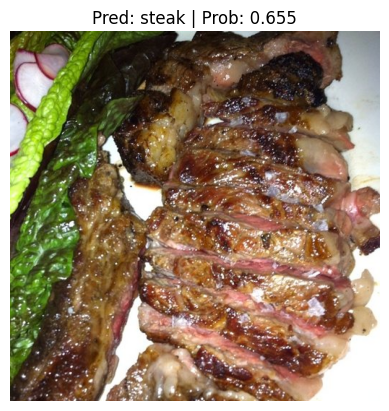

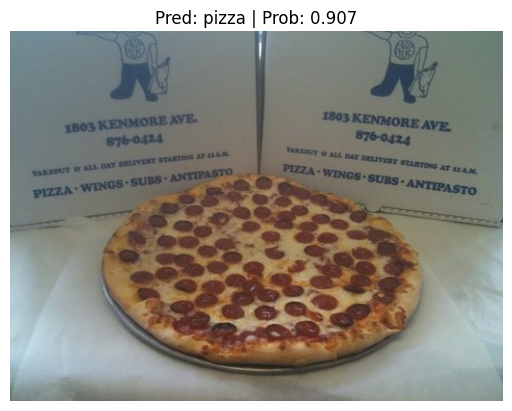

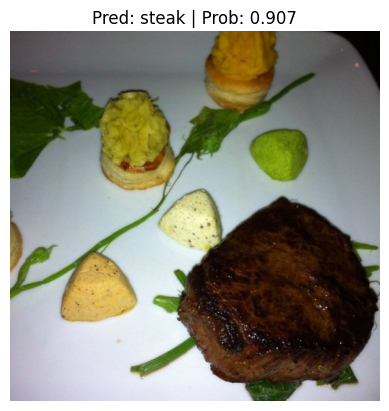

In [30]:
# Import function to make predictions on images and plot them 
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

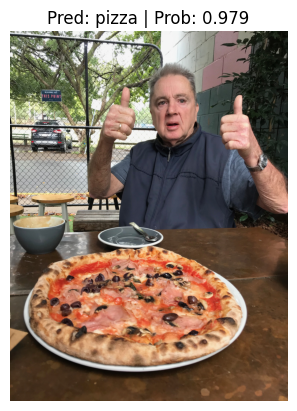

In [31]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)